In [1]:
%matplotlib inline
%config IPCompleter.greedy=True

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display
import matplotlib
from matplotlib import pyplot as plt
import importlib
from datetime import timedelta

#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

#Path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

In [2]:
#For GPUOcean
from SWESimulators import CDKLM16, Common, IPythonMagic, NetCDFInitialization
from SWESimulators import GPUDrifterCollection, Observation
from SWESimulators import DataAssimilationUtils as dautils
from demos.realisticSimulations import norkyst_plotting

#For Opendrift
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.oceandrift import OceanDrift

#For OceanParcels
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, Field

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
def simulate_parcels(source_url, output_filename, lat, lon, wind_drift_percentage, velocity_average, hours=23):
    filenames = {'U' : source_url, 'V': source_url}
    dimensions = {'lat': 'lat','lon': 'lon','time': 'time'}

    if velocity_average: 
        variables = {'U': 'ubar', 'V': 'vbar'}
    else:
        variables = {'U': 'u', 'V': 'v'}

    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, interp_method = 'cgrid_velocity')
    
    if wind_drift_percentage:
        Uwind = Field.from_netcdf(source_url, ('U', 'Uwind'), dimensions, field_chunksize='auto', interp_method = 'cgrid_velocity')
        Vwind = Field.from_netcdf(source_url, ('V', 'Vwind'), dimensions, field_chunksize='auto', interp_method = 'cgrid_velocity')
        Uwind.set_scaling_factor(wind_drift_percentage)
        Vwind.set_scaling_factor(wind_drift_percentage)
        fieldset = FieldSet(U = fieldset.U+ Uwind,V = fieldset.V+ Vwind)

    pset = ParticleSet.from_list(fieldset = fieldset, pclass = JITParticle, lon=lon, lat=lat)
    output_file = pset.ParticleFile(name = output_filename, outputdt = timedelta(minutes=15))

    pset.execute(AdvectionRK4, runtime = timedelta(hours = hours), dt = timedelta(minutes=5), output_file = output_file)

    output_file.export()

In [5]:
def simulate_opendrift(source_url, lat, lon, wind_drift_percentage, velocity_average, hours=23):
    reader_norkyst = reader_netCDF_CF_generic.Reader(source_url)
    o = OceanDrift(loglevel=20)
    
    if velocity_average:
        reader_norkyst.variable_mapping['x_sea_water_velocity'] = 'ubar'
        reader_norkyst.variable_mapping['y_sea_water_velocity'] = 'vbar'
    
    o.add_reader(reader_norkyst, variables=['x_sea_water_velocity', 'y_sea_water_velocity', 'x_wind', 'y_wind'])
    
    o.seed_elements(lon= lon, lat=lat, radius=1, number=1, time=reader_norkyst.start_time, wind_drift_factor = wind_drift_percentage)
    
    o.set_config('drift:scheme', 'runge-kutta4')
    
    o.run(duration = timedelta(hours=hours), time_step = 300, time_step_output = 900)
    
    return o

In [6]:
def initlonlat2initgpuocean(opendrift_obj, X_norkyst, Y_norkyst, lon, lat, num_cells_x, num_cells_y, res = 800):
    #Finding tentative x,y(not for a specific domain)
    x, y = opendrift_obj.lonlat2xy(lon,lat)

    #Given x,y, num_cells_x, num_cells_y and resolution: specify domain in gpuocean
    x0, x1 = x//res - num_cells_x, x//res + num_cells_x 
    y0, y1 = y//res - num_cells_y, y//res + num_cells_y

    #Find new x,y in gpuocean coordinates for initial position
    xinit = x - X[int(x0) + 2]
    yinit = y- Y[int(y0) + 2]
    
    return xinit, yinit, int(x0), int(x1), int(y0), int(y1)

In [7]:
#Motsatt vei?
def gpuocean2lonlat(opendrift_obj, X_norkyst, Y_norkyst, x, y, x0, y0):
    x = x + X_norkyst[x0+2]
    y = y + Y_norkyst[y0+2]
    
    lon, lat = opendrift_obj.xy2lonlat(x,y)

    return lon, lat

In [19]:
def opendriftObj2gpuoceanObs(opendrift_obj,X_norkyst, Y_norkyst, x0, x1,y0,y1, res = 800,  land_mask = None):
    t = opendrift_obj.get_time_array()[1]
    for i in range(len(t)):
        t[i] = t[i].total_seconds()
    t = np.array(t)

    lon, lat = opendrift_obj.get_lonlats()
    x,y = opendrift_obj.lonlat2xy(lon,lat)
    
    x = x - X_norkyst[x0 +2] # in m
    y = y- Y_norkyst[y0 +2] # in m
    
    #TODO: Remove drifters ouside the domain

    nx = (x1-x0-4) #num_cells
    ny = (y1-y0-4) #num_cells
    
    obs = Observation.Observation(domain_size_x = nx*res,
                                    domain_size_y = ny*res,
                                    nx=x1-x0-4, ny=y1-y0-4, land_mask = land_mask)
    
    obs.add_observations_from_arrays(t,x,y) #x,y i m fra origin i gpuocean ?
    
    return obs

In [74]:
def parcelsFile2gpuoceanObs(filename, opendrift_obj, X_norkyst, Y_norkyst, x0, x1, y0,y1, res = 800, land_mask = None):
    pfile = Dataset(filename)
    t = pfile.variables['time'][0,:]
    lon = np.ma.filled(pfile.variables['lon'], np.nan)
    lat = np.ma.filled(pfile.variables['lat'], np.nan)
    pfile.close()

    x,y = opendrift_obj.lonlat2xy(lon,lat)
    
    x = x - X_norkyst[x0 +2] # in m
    y = y- Y_norkyst[y0 +2] # in m
    
    #TODO: Remove drifters ouside the domain

    nx = (x1-x0-4) #num_cells
    ny = (y1-y0-4) #num_cells
    
    obs = Observation.Observation(domain_size_x = nx*res,
                                    domain_size_y = ny*res,
                                    nx=x1-x0-4, ny=y1-y0-4, land_mask = land_mask)
    
    obs.add_observations_from_arrays(t,x,y) #x,y i m fra origin i gpuocean ?
    
    return obs

In [9]:
#Simulating gpu-ocean run OBS: only trajectory output
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "rk_order": 2,
    "desingularization_eps": 1.0
     }

outfolder = 'deterministic_forecast_test'

def simulate_gpuocean_deterministic(source_url, domain, initx, inity, erode_land, sim_args,observation_type = dautils.ObservationType.UnderlyingFlow, outfolder = None, start_forecast_hours = 0, forecast_duration = 23 ):
    
    end_forecast_hours = start_forecast_hours + forecast_duration
    
    #Create simulator
    data_args = NetCDFInitialization.getInitialConditions(source_url, domain[0], domain[1], domain[2],domain[3] , 
                     timestep_indices = None, erode_land = erode_land, download_data = False)

    importlib.reload(CDKLM16)
    sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))
    
    #Forecast
    observation_args = {'observation_type': observation_type,
                    'nx': sim.nx, 'ny': sim.ny,
                    'domain_size_x': sim.nx*sim.dx,
                    'domain_size_y': sim.ny*sim.dy,
                    'land_mask': sim.getLandMask()
                   }

    trajectory_forecast = Observation.Observation(**observation_args)

    if outfolder is not None:
        out_folder = os.path.abspath(outfolder)
        os.makedirs(out_folder, exist_ok=True)
        trajectory_forecast_filename = 'trajectory_forecast_'+str(start_forecast_hours)+'_to_'+str(end_forecast_hours)+'.pickle'
        trajectory_forecast_path = os.path.join(out_folder, trajectory_forecast_filename)
    
    #Drifters
    #Assumes initx, inity same format/shape
    if type(initx) is not list:
        initx = [initx]
        inity = [inity]
    
    num_drifters = len(initx)
    
    drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters, 
                                                     boundaryConditions = sim.boundary_conditions,
                                                     domain_size_x = trajectory_forecast.domain_size_x,
                                                     domain_size_y = trajectory_forecast.domain_size_y,
                                                     gpu_stream = sim.gpu_stream)
    
    drifter_pos_init = np.array([initx, inity]).T
    
    #Run simulation
    num_total_hours = end_forecast_hours
    
    five_mins_in_an_hour = 12
    sub_dt = 5*60 # five minutes
    
    progress = Common.ProgressPrinter(5)
    pp = display(progress.getPrintString(0), display_id=True)

    for hour in range(num_total_hours):
        
        if hour == start_forecast_hours:
            # Attach drifters
            drifters.setDrifterPositions(drifter_pos_init)
            sim.attachDrifters(drifters)
            trajectory_forecast.add_observation_from_sim(sim)
        
        for mins in range(five_mins_in_an_hour):
            t = sim.step(sub_dt)
            if hour >= start_forecast_hours:
                trajectory_forecast.add_observation_from_sim(sim)
        
        pp.update(progress.getPrintString(hour/(end_forecast_hours-1)))
    
    if outfolder is not None:
        trajectory_forecast.to_pickle(trajectory_forecast_path)
    
    return trajectory_forecast


In [10]:
def createForecastCanvas(observation):
    
    nx = observation.nx
    ny = observation.ny
    
    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111)
    
    extent=np.array([0, observation.domain_size_x, 0, observation.domain_size_y])/800 #Hvorfor deles det på 1000 her?
    ax.imshow(observation.land_mask, origin="lower", 
              extent=extent, cmap='binary')

    return ax

def forecastPlot(ax, true_paths, ensemble_paths, color_id=0, 
                 forecast_point_size=2, truth_point_size=6, mean_paths=[None]):
    """
    ax: Axis object to draw trajectories in
    true_path: A single list of paths that represents the truth
    ensemble_paths: Multiple lists of paths that represents the forecast
    color_id: integer representing a pre-defined color combination.
    """

    color_combinations = [
        # [true color, forecast color]
        #['xkcd:dark grey blue', 'xkcd:light blue grey', 'xkcd:wine'],
        ['xkcd:scarlet', 'xkcd:light blue grey', 'xkcd:dark grey blue'],
        ['xkcd:viridian', 'xkcd:foam green', 'xkcd:dark grey green'],
        ['g', 'xkcd:foam green', 'xkcd:dark grey green']
    ]
    
    assert(color_id < len(color_combinations)), 'Invalid color_id'
    
    true_color = color_combinations[color_id][0]
    forecast_color = color_combinations[color_id][1]
    mean_color = color_combinations[color_id][2]

    # Plot forecast paths 
    for paths in ensemble_paths:
        for path in paths:
            ax.plot(path[:,0], path[:,1], color=forecast_color, alpha=0.3)
        
        # Mark end position of forecast
        end_position   = paths[-1][-1,:]
        circ_end_forecast = matplotlib.patches.Circle((end_position[0], end_position[1]), 
                                                      forecast_point_size, 
                                                      fill=False, zorder=10,
                                                      alpha=0.7)
        ax.add_patch(circ_end_forecast)

    
    # Plot true path
    for path in true_paths:
        ax.plot(path[:,0], path[:,1], color=true_color, zorder=5)
    
    # Plot mean path
    if mean_paths[0] is not None:
        for path in mean_paths:
            ax.plot(path[:,0], path[:,1], color=mean_color, zorder=6)
    
    # Mark start and end of true path
    start_pos = true_paths[0][0,:]
    end_pos   = true_paths[-1][-1,:]
    circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                           truth_point_size,
                                           fill=False, zorder=10)
    ax.add_patch(circ_start)
    #circ_end = matplotlib.patches.Circle((end_pos[0], end_pos[1]), 
    #                                     truth_point_size,
    #                                     fill=False, zorder=10)
    #ax.add_patch(circ_end)
    ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)
    
    # Mark end of mean path
    if mean_paths[0] is not None:
        #xend = matplotlib.patches.Circle((mean_paths[-1][-1,0], mean_paths[-1][-1,1]),
        #                                 truth_point_size,
        #                                 fill=False, zorder=10)
        #ax.add_patch(xend)
        ax.plot(mean_paths[-1][-1,0], mean_paths[-1][-1,1], 
                   marker='o', markeredgecolor='k', markerfacecolor=None)

def plotAllDrifters(obs_file, drifter_ids=None, ax = None):
    
    if drifter_ids is None:
        drifter_ids = np.arange(obs_file.get_num_drifters(ignoreBuoys=True))
    
    num_drifters = len(drifter_ids)
    
    drifter_paths = [None]*num_drifters

    forecast_start_t = 0
    forecast_end_t = 23*3600


    for i in range(num_drifters):
        drifter_paths[i] = obs_file.get_drifter_path(drifter_ids[i], forecast_start_t, forecast_end_t)

    if ax is None:
        ax = createForecastCanvas(trajectory_forecast)
    for drifter_path in drifter_paths:
        forecastPlot(ax, drifter_path, [], truth_point_size=1)

In [11]:
source_url =  ['/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc', 
               '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc', 
               '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc']
source_url = '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc'
url = source_url

#Save X, Y(dimensions) from netcdf file from norkyst800
ncfile = Dataset(source_url)
X = ncfile.variables['X'][:]
Y = ncfile.variables['Y'][:]
ncfile.close()

#Create OpendriftObject with norkys data to access coordinate-change lonlat2xy
reader_norkyst = reader_netCDF_CF_generic.Reader(source_url)
o = OceanDrift(loglevel=50)
o.add_reader(reader_norkyst, variables=['x_sea_water_velocity', 'y_sea_water_velocity'])

lon, lat = 4.3, 61.5

In [12]:

o1 = simulate_opendrift(source_url, lat, lon, 0.0, True, 12) #no wind, average velocity


11:26:16 INFO: OpenDriftSimulation initialised (version 1.2.3)
11:26:16 INFO: Config validation OK
11:26:16 INFO: Adding a dynamical landmask with max. priority based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
11:26:20 INFO: Using existing reader for land_binary_mask
11:26:20 INFO: All points are in ocean
11:26:20 INFO: 2019-07-18 00:00:00 - step 1 of 144 - 1 active elements (0 deactivated)
11:26:20 INFO: 2019-07-18 00:05:00 - step 2 of 144 - 1 active elements (0 deactivated)
11:26:20 INFO: 2019-07-18 00:10:00 - step 3 of 144 - 1 active elements (0 deactivated)
11:26:20 INFO: 2019-07-18 00:15:00 - step 4 of 144 - 1 active elements (0 deactivated)
11:26:20 INFO: 2019-07-18 00:20:00 - step 5 of 144 - 1 active elements (0 deactivated)
11:26:20 INFO: 2019-07-18 00:25:00 - step 6 of 144 - 1 active elements (0 deactivated)
11:26:20 INFO: 2019-07-18 00:30:00 - step 7 of 144 - 1 active elements (0 deactivated)
11:26:20 INFO: 2019-07-18 00:35:00 - step 8 of

11:26:21 INFO: 2019-07-18 07:30:00 - step 91 of 144 - 1 active elements (0 deactivated)
11:26:21 INFO: 2019-07-18 07:35:00 - step 92 of 144 - 1 active elements (0 deactivated)
11:26:21 INFO: 2019-07-18 07:40:00 - step 93 of 144 - 1 active elements (0 deactivated)
11:26:21 INFO: 2019-07-18 07:45:00 - step 94 of 144 - 1 active elements (0 deactivated)
11:26:21 INFO: 2019-07-18 07:50:00 - step 95 of 144 - 1 active elements (0 deactivated)
11:26:21 INFO: 2019-07-18 07:55:00 - step 96 of 144 - 1 active elements (0 deactivated)
11:26:21 INFO: 2019-07-18 08:00:00 - step 97 of 144 - 1 active elements (0 deactivated)
11:26:21 INFO: 2019-07-18 08:05:00 - step 98 of 144 - 1 active elements (0 deactivated)
11:26:21 INFO: 2019-07-18 08:10:00 - step 99 of 144 - 1 active elements (0 deactivated)
11:26:21 INFO: 2019-07-18 08:15:00 - step 100 of 144 - 1 active elements (0 deactivated)
11:26:21 INFO: 2019-07-18 08:20:00 - step 101 of 144 - 1 active elements (0 deactivated)
11:26:21 INFO: 2019-07-18 08:2

In [20]:
initx, inity, x0,x1, y0,y1 = initlonlat2initgpuocean(o, X, Y, lon, lat, 50,50)
o1obs = opendriftObj2gpuoceanObs(o1, X, Y, x0, x1,y0,y1)

In [21]:
domain = [x0,x1,y0,y1]
gpuobs = simulate_gpuocean_deterministic(source_url, domain, initx, inity, erode_land = 1, sim_args = sim_args, outfolder = None, forecast_duration = 12 )

'0% [##############################] 100%. Total: 18s, elapsed: 18s, remaining: 0s'

In [57]:
simulate_parcels(source_url, 'parcels_ex.nc', lat,lon,0.0,True,12) #no wind, average velocity

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/56935b2e345206027dd0cbeba07291ee_0.so
INFO:parcels.tools.loggers:Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/56935b2e345206027dd0cbeba07291ee_0.so
INFO: Temporary output files are stored in out-BBESBGXN.
INFO:parcels.tools.loggers:Temporary output files are stored in out-BBESBGXN.
INFO: You can use "parcels_convert_npydir_to_netcdf out-BBESBGXN" to convert these to a NetCDF file during the run.
INFO:parcels.tools.loggers:You can use "parcels_convert_npydir_to_netcdf out-BBESBGXN" to convert these to a NetCDF file during the run.
100% (43200.0 of 43200.0) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


In [71]:
pfile = Dataset('parcels_ex.nc')
t = pfile.variables['time']
lon = np.ma.filled(pfile.variables['lon'], np.nan)
lat = np.ma.filled(pfile.variables['lat'], np.nan)
print(t[0,:])
pfile.close()

[    0.   900.  1800.  2700.  3600.  4500.  5400.  6300.  7200.  8100.
  9000.  9900. 10800. 11700. 12600. 13500. 14400. 15300. 16200. 17100.
 18000. 18900. 19800. 20700. 21600. 22500. 23400. 24300. 25200. 26100.
 27000. 27900. 28800. 29700. 30600. 31500. 32400. 33300. 34200. 35100.
 36000. 36900. 37800. 38700. 39600. 40500. 41400. 42300. 43200.]


In [75]:
pobs = parcelsFile2gpuoceanObs('parcels_ex.nc', o1, X, Y, x0, x1, y0,y1)

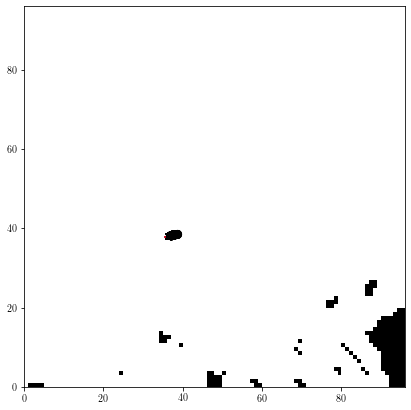

In [79]:
%matplotlib inline
ax = createForecastCanvas(gpuobs)
plotAllDrifters(gpuobs, ax= ax)
plotAllDrifters(pobs, ax = ax)
plotAllDrifters(pobs, ax=ax)

In [23]:
xx, yy = o1.lonlat2xy(4.3, 61.5)
print(xx- X[x0+2], initx)
print(yy- Y[y0+2], inity)

38754.99137502536 38754.99137502536
38488.85908033745 38488.85908033745


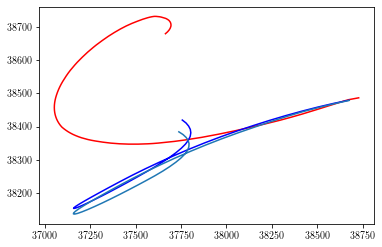

In [78]:
ptraj = pobs.get_drifter_path(0,0,12*3600, in_km = False)
xp = ptraj[0].T[0]
yp = ptraj[0].T[1]
traj = o1obs.get_drifter_path(0,0,12*3600, in_km = False) #End_time in seconds
xo = traj[0].T[0]
yo = traj[0].T[1]
trajectory = gpuobs.get_drifter_path(0, 0,23*3*3600, in_km = False) #End_time in seconds here
xg = trajectory[0].T[0]
yg = trajectory[0].T[1]

fig, ax = plt.subplots(1, 1)

lon, lat = o1.get_lonlats()
x_,y_ = o1.lonlat2xy(lon, lat)
x_ -= X[x0+2]
y_ -= Y[y0+2]

ax.plot(xg, yg, color = 'red')
ax.plot(xo, yo, color = 'blue')
ax.plot(xp,yp)
#ax.plot(x_,y_)

olon, olat = gpuocean2lonlat(o, X, Y, xo,yo,x0,y0)
glon, glat = gpuocean2lonlat(o, X, Y, xg, yg, x0, y0)

#fig, ax2 = plt.subplots(1,1)
#ax2.plot(olon.T, olat.T, color = 'blue')
#ax2.plot(glon.T,glat.T, color = 'red')
#ax2.plot(lon.T, lat.T, color = 'red')
